In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVR

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

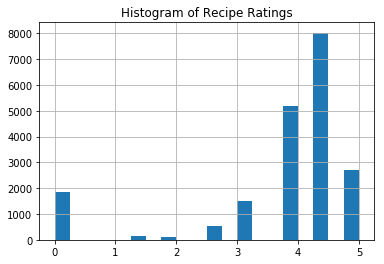

In [3]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.


In [4]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [5]:
# svr = SVR()
# X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
# Y = raw_data.rating
# svr.fit(X,Y)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

In [6]:
# svr.score(X, Y)

In [7]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(svr, X, Y, cv=5)

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

### Assignment begins here.

In [8]:
# Rating recipes good/bad with greater than 3.5 being good.
def binary_rating(rating):
    if rating > 3.5:
        return 1.0
    else:
        return 0.0
    
raw_data['binary_rating'] = raw_data.rating.apply(lambda x: binary_rating(x))

In [9]:
# A DataFrame with all the positive reviews, another with negatives
raw_data_positive = raw_data[raw_data.binary_rating == 1]
raw_data_negative = raw_data[raw_data.binary_rating == 0]

In [10]:
# Creating list of tuples with all columns and the p-value comparing their
# averages in positive vs. negative reviews
from scipy.stats import ttest_ind
lst = []

for col in raw_data.drop(columns='title'):
    tt = ttest_ind(raw_data_positive[col], raw_data_negative[col], equal_var=False)
    lst.append((col,tt))

In [11]:
# Creating a list with feature names when p-value was under .05
keeper_vars = []
adios_vars = []
for num in range(len(lst)):
    if lst[num][1][1] < .05:
        keeper_vars.append(lst[num][0])
    else:
        adios_vars.append(lst[num][0])
    
    

In [12]:
keeper_df = raw_data.loc[:, keeper_vars]

In [13]:
# Eliminating features with less than 1200 positive reviews.
for col in keeper_df:
    if keeper_df[col].mean() < (1200/len(keeper_df)):
        del keeper_df[col]

In [14]:
keeper_df.shape

(20052, 39)

In [15]:
from sklearn.svm import SVC

svc = SVC()
X = keeper_df.drop(columns=['rating', 'binary_rating'])
y = keeper_df.binary_rating

svc.fit(X, y)

svc.score(X, y)

0.7932874526231797

I should still try doing something with the nutritional information.

It looks like there are some crazy numbers in the nutrition information and it needs to be cleaned up.

In [16]:
# raw_pfcs has only semi-reasonable listings for protein, fat, calories, and sodium
raw_p = raw_data[raw_data.protein <= 200].dropna()
raw_pf = raw_p[raw_p.fat <= 200].dropna()
raw_pfc = raw_pf[raw_pf.calories <= 3000]
raw_pfcs = raw_pfc[raw_pfc.sodium <= 10000]

In [17]:
nutrition = ['sodium', 'protein', 'calories', 'fat']
nutrit_features = raw_pfcs.loc[:, list(keeper_df.columns)+nutrition]

X2 = nutrit_features.drop(columns=['rating', 'binary_rating'])
y2 = nutrit_features.binary_rating

In [18]:
nut_svc = SVC()

nut_svc.fit(X2, y2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
# Goal was to whittle it down to 30 features... eh, close enough
X2.shape

(15543, 41)

In [20]:
nut_svc.score(X2, y2)

0.943640223895001

Seems pretty accurate with the nutrition info included. But how do I interpret my results?

My model can predict if a recipe will  be liked. But I can't tell how to craft a recipe that will be liked.